In [2]:
import wandb
import ast
import argparse
import os
import networkx as nx
from lineflow.helpers import get_device
from lineflow.learning.helpers import (
    make_stacked_vec_env,
)
from lineflow.learning.curriculum import CurriculumLearningCallback
from lineflow.examples import (
    MultiProcess,
    WorkerAssignment,
    ComplexLine,
    WaitingTime,
)
from sb3_contrib import (
    RecurrentPPO,
    TRPO,
)
from stable_baselines3.common.callbacks import (
    CallbackList,
    EvalCallback,
)
from stable_baselines3 import (
    PPO,
    A2C,
)
import torch_geometric as pyg
from wandb.integration.sb3 import WandbCallback

In [3]:
import numpy as np
from lineflow.simulation import (
    Source,
    Sink,
    Line,
    Assembly,
)



def make_agent_fixed_waiting_time(line, waiting_time):
    waiting_times = line['S_component'].state['waiting_time'].categories

    def agent(state, env):
        """
        A policy that can effectively set float waiting times by
        alternating between ints
        """

        index = np.argmin(np.abs(waiting_times - waiting_time))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


def compute_optimal_waiting_time(line):
    time_assembly = line['Assembly'].processing_time*1.1 + 1 + 1 + 1.1
    time_source = line['S_component'].processing_time*1.1 + 1.1
    return time_assembly-time_source


def make_optimal_agent(line):

    waiting_times = line['S_component'].state['waiting_time'].categories
    processing_time_source = line['S_component'].processing_time

    def agent(state, env):
        """
        A policy that can effectively set float waiting times by
        alternating between ints
        """
        time_assembly = state['Assembly']['processing_time'].value + 1 + 1 + 1.1
        time_source = processing_time_source*1.1 + 1.1
        waiting_time = time_assembly - time_source

        index = np.argmin(np.abs(waiting_times - waiting_time))
        actions = {}
        actions['S_component'] = {'waiting_time': index}
        return actions
    return agent


class WTAssembly(Assembly):

    def __init__(
        self,
        name,
        R=0.75,
        t_jump_max=2000,
        **kwargs,
    ):

        self.R = R
        self.t_jump_max = t_jump_max
        self.trigger_time = None
        self.factor = None

        super().__init__(name=name,  **kwargs)

    def init(self, random):
        """
        Function that is called after line is built, so all available information is present
        """
        super().init(random)

        self._sample_trigger_time()

    def _compute_scaling_factor(self, T_jump, E=3.1):

        T = self.processing_time
        S = self.processing_std
        T_sim = self.t_jump_max*2

        return 1/T*((T_jump*(T+S+E)) / ((self.R-1)*T_sim+T_jump) - S -E)


    def _sample_trigger_time(self):

        self.t_jump = np.random.uniform(
            0.8*self.t_jump_max,
            self.t_jump_max,
        )

        self.factor = self._compute_scaling_factor(self.t_jump)
        self.trigger_time = self.random.uniform(0.25, 0.75)*self.t_jump_max

    def _sample_exp_time(self, time=None, scale=None, rework_probability=0):
        """
        Samples a time from an exponential distribution
        """
        coeff = self.get_performance_coefficient()
        if self.trigger_time < self.env.now < self.trigger_time + self.t_jump:
            factor = self.factor
        else: 
            factor = 1

        return time*factor*coeff + self.random.exponential(scale=scale)



class WaitingTime(Line):
    def __init__(
        self, 
        processing_time_source=5, 
        transition_time=5, 
        with_jump=False,
        t_jump_max=None,
        assembly_condition=35,
        scrap_factor=1,
        R=0.75,
        **kwargs,
    ):
        self.processing_time_source = processing_time_source
        self.transition_time = transition_time
        self.with_jump = with_jump
        self.t_jump_max = t_jump_max
        self.assembly_condition = assembly_condition
        self.R = R
        self.components = None
        self.graph_info = None
        if self.with_jump:
            assert self.t_jump_max is not None
        super().__init__(scrap_factor=scrap_factor, **kwargs)

    def build(self):
        self.graph_info = {
            'nodes': {},
            'edges': [],
            'metadata': {}
        }
        source_main = Source(
            'S_main',
            position=(300, 300),
            processing_time=0,
            carrier_capacity=2,
            actionable_waiting_time=False,
            unlimited_carriers=True,
        )
        # Record node information
        self.graph_info['nodes']['S_main'] = {
            'type': 'Source',
            'processing_time': 0,
            'carrier_capacity': 2,
            'actionable_waiting_time': False,
            'properties': {
                'is_main_source': True,
                'controllable': False
            }
        }
        source_component = Source(
            'S_component',
            position=(500, 450),
            processing_time=self.processing_time_source,
            waiting_time=0,
            waiting_time_step=1,
            carrier_capacity=1,
            part_specs=[{
                "assembly_condition": self.assembly_condition
            }],
            unlimited_carriers=True,
            actionable_waiting_time=True,
        )
        self.graph_info['nodes']['S_component'] = {
            'type': 'Source',
            'processing_time': self.processing_time_source,
            'waiting_time': 0,
            'waiting_time_step': 1,
            'carrier_capacity': 1,
            'part_specs': [{"assembly_condition": self.assembly_condition}],
            'actionable_waiting_time': True,
            'properties': {
                'is_component_source': True,
                'controllable': True
            }
        }
        if self.with_jump:
            assembly = WTAssembly(
                'Assembly',
                t_jump_max=self.t_jump_max,
                position=(500, 300),
                R=self.R,
                processing_time=20,
                NOK_part_error_time=5,
            )
            self.graph_info['nodes']['Assembly'] = {
                'type': 'WTAssembly',
                'processing_time': 20,
                'NOK_part_error_time': 5,
                't_jump_max': self.t_jump_max,
                'R': self.R,
                'properties': {
                    'has_jump_behavior': True,
                    'is_assembly': True
                }
            }
        else:
            assembly = Assembly(
                'Assembly',
                position=(500, 300),
                processing_time=20,
                NOK_part_error_time=5,
            )
            self.graph_info['nodes']['Assembly'] = {
                'type': 'Assembly',
                'processing_time': 20,
                'NOK_part_error_time': 5,
                'properties': {
                    'has_jump_behavior': False,
                    'is_assembly': True
                }
            }


        sink = Sink('Sink', processing_time=0, position=(700, 300))
        self.graph_info['nodes']['Sink'] = {
            'type': 'Sink',
            'processing_time': 0,
            'properties': {
                'is_sink': True
            }
        }
        assembly.connect_to_component_input(
            station=source_component,
            capacity=3,
            transition_time=self.transition_time,
        )
        self.graph_info['edges'].append({
            'source': 'S_component',
            'target': 'Assembly',
            'connection_type': 'component_input',
            'capacity': 3,
            'transition_time': self.transition_time,
            'properties': {
                'is_component_feed': True
            }
        })
        assembly.connect_to_input(source_main, capacity=2, transition_time=2)
        self.graph_info['edges'].append({
            'source': 'S_main',
            'target': 'Assembly',
            'connection_type': 'standard_input',
            'capacity': 2,
            'transition_time': 2,
            'properties': {
                'is_main_feed': True
            }
        })
        
        sink.connect_to_input(assembly, capacity=2, transition_time=2)

        self.graph_info['edges'].append({
            'source': 'Assembly',
            'target': 'Sink',
            'connection_type': 'standard_input',
            'capacity': 2,
            'transition_time': 2,
            'properties': {
                'is_output': True
            }
        })


In [4]:
def build_graph_from_info(graph_info, output_format='dict'):
    """
    Reconstruct graph from recorded graph_info
    """
    if output_format == 'networkx':
        import networkx as nx
        G = nx.DiGraph()
        
        # Add nodes with attributes
        for node_name, node_data in graph_info['nodes'].items():
            G.add_node(node_name, **node_data)
        
        # Add edges with attributes
        for edge_data in graph_info['edges']:
            G.add_edge(
                edge_data['source'], 
                edge_data['target'],
                **{k: v for k, v in edge_data.items() if k not in ['source', 'target']}
            )
        
        return G
    
    elif output_format == 'heterodata':
        from torch_geometric.data import HeteroData
        import torch
        
        data = HeteroData()
        
        # Group nodes by type
        node_types = {}
        for node_name, node_data in graph_info['nodes'].items():
            node_type = node_data['type']
            if node_type not in node_types:
                node_types[node_type] = []
            node_types[node_type].append((node_name, node_data))
        
        # Create node features and mappings
        node_mapping = {}
        for node_type, nodes in node_types.items():
            features = []
            for i, (node_name, node_data) in enumerate(nodes):
                # Create feature vector from recorded data
                feat_vector = [
                    node_data.get('processing_time', 0),
                    node_data.get('position', [0, 0])[0] / 1000,
                    node_data.get('position', [0, 0])[1] / 1000,
                    node_data.get('carrier_capacity', 1),
                ]
                features.append(feat_vector)
                node_mapping[node_name] = (node_type, i)
            
            data[node_type].x = torch.tensor(features, dtype=torch.float)
        
        # Group and add edges
        edge_types = {}
        for edge_data in graph_info['edges']:
            source_name = edge_data['source']
            target_name = edge_data['target']
            
            source_type = node_mapping[source_name][0]
            target_type = node_mapping[target_name][0]
            
            edge_type = (source_type, 'connects_to', target_type)
            
            if edge_type not in edge_types:
                edge_types[edge_type] = []
            
            source_idx = node_mapping[source_name][1]
            target_idx = node_mapping[target_name][1]
            edge_types[edge_type].append([source_idx, target_idx])
        
        # Add edges to HeteroData
        for edge_type, edge_list in edge_types.items():
            if edge_list:
                edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
                data[edge_type].edge_index = edge_index
        
        return data
    
    else:  # Return as dictionary
        return graph_info

# Usage
def get_line_graph(line, format='heterodata'):
    """
    Get graph representation from a line
    """
    if not hasattr(line, 'graph_info'):
        # If graph_info not recorded, extract from built components
        line.reset()  # This calls build() which should populate graph_info
    
    return build_graph_from_info(line.graph_info, output_format=format)

In [5]:
line = WaitingTime()
data = get_line_graph(line)

In [6]:
def hetero_to_networkx(data):
    G = nx.MultiDiGraph()

    # Add nodes
    for node_type in data.node_types:
        for i in range(data[node_type].num_nodes):
            G.add_node((node_type, i), node_type=node_type)

    # Add edges with types
    for edge_type in data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = data[edge_type].edge_index
        for src, dst in zip(edge_index[0], edge_index[1]):
            G.add_edge((src_type, int(src)), (dst_type, int(dst)), key=rel_type, rel_type=rel_type)

    return G


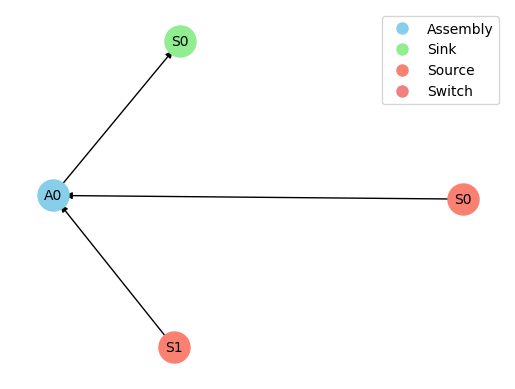

In [7]:
import matplotlib.pyplot as plt
G = hetero_to_networkx(data)

# Layout
pos = nx.spring_layout(G, seed=42)

# Draw nodes with type labels
node_colors = {
    'Assembly': 'skyblue',
    'Sink': 'lightgreen',
    'Source': 'salmon',
    'Switch': 'lightcoral'
}
for node_type in data.node_types:
    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[n for n in G.nodes if n[0] == node_type],
        node_color=node_colors[node_type],
        label=node_type,
        node_size=500
    )

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=True)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={n: f"{n[0][0]}{n[1]}" for n in G.nodes}, font_size=10)

# Legend
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Assembly', markerfacecolor='skyblue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Sink', markerfacecolor='lightgreen', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Source', markerfacecolor='salmon', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Switch', markerfacecolor='lightcoral', markersize=10)
])
plt.axis('off')
plt.show()
